In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fft2, fftshift
from scipy.signal import windows
import seaborn as sns
from typing import Tuple, Dict, List
import warnings
import os

warnings.filterwarnings('ignore')

# Configure for Colab display
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100
sns.set_palette("husl")

In [27]:
class RadarSignalGenerator:
    """
    Professional radar signal generator for mmWave applications.

    Attributes:
        f_c (float): Carrier frequency in Hz
        bandwidth (float): Chirp bandwidth in Hz
        sweep_time (float): Chirp duration in seconds
        num_chirps (int): Number of chirps per frame
        adc_samples (int): ADC samples per chirp
        c (float): Speed of light in m/s
    """

    def __init__(
        self,
        carrier_freq: float = 77e9,
        bandwidth: float = 4e9,
        sweep_time: float = 40e-6,
        num_chirps: int = 128,
        adc_samples: int = 256
    ):
        """Initialize radar parameters following mmWave standards."""
        self.f_c = carrier_freq
        self.bandwidth = bandwidth
        self.sweep_time = sweep_time
        self.num_chirps = num_chirps
        self.adc_samples = adc_samples
        self.c = 3e8  # Speed of light

        # Derived parameters
        self.range_resolution = self.c / (2 * self.bandwidth)
        self.max_range = (self.c * self.adc_samples) / (4 * self.bandwidth / self.sweep_time)
        self.velocity_resolution = self.c / (2 * self.f_c * self.num_chirps * self.sweep_time)

        print(f"Radar Configuration:")
        print(f"  Range Resolution: {self.range_resolution:.3f} m")
        print(f"  Max Range: {self.max_range:.2f} m")
        print(f"  Velocity Resolution: {self.velocity_resolution:.3f} m/s")

    def generate_1d_signal(
        self,
        target_range: float,
        target_velocity: float = 0.0,
        rcs: float = 1.0,
        noise_power: float = 0.01
    ) -> np.ndarray:
        """
        Generate 1D radar signal (single chirp).

        Args:
            target_range: Distance to target in meters
            target_velocity: Target velocity in m/s
            rcs: Radar cross-section (amplitude factor)
            noise_power: Noise power level

        Returns:
            Complex baseband signal
        """
        # Time vector for single chirp
        t = np.linspace(0, self.sweep_time, self.adc_samples)

        # Calculate beat frequency (range information)
        slope = self.bandwidth / self.sweep_time
        time_delay = 2 * target_range / self.c
        f_beat = slope * time_delay

        # Doppler frequency shift
        f_doppler = 2 * target_velocity * self.f_c / self.c

        # Generate signal: I/Q channels
        phase = 2 * np.pi * (f_beat + f_doppler) * t
        signal = rcs * np.exp(1j * phase)

        # Add complex Gaussian noise
        noise = np.sqrt(noise_power / 2) * (
            np.random.randn(self.adc_samples) +
            1j * np.random.randn(self.adc_samples)
        )

        return signal + noise

    def generate_2d_signal(
        self,
        targets: List[Dict],
        noise_power: float = 0.01
    ) -> np.ndarray:
        """
        Generate 2D radar datacube (multiple chirps).

        Args:
            targets: List of target dictionaries with keys:
                    'range', 'velocity', 'rcs'
            noise_power: Noise power level

        Returns:
            2D array [num_chirps x adc_samples]
        """
        datacube = np.zeros((self.num_chirps, self.adc_samples), dtype=complex)

        # Generate signal for each chirp
        for chirp_idx in range(self.num_chirps):
            chirp_signal = np.zeros(self.adc_samples, dtype=complex)

            # Add contribution from each target
            for target in targets:
                target_signal = self.generate_1d_signal(
                    target_range=target['range'],
                    target_velocity=target['velocity'],
                    rcs=target['rcs'],
                    noise_power=0  # Add noise separately
                )
                chirp_signal += target_signal

            # Add noise
            noise = np.sqrt(noise_power / 2) * (
                np.random.randn(self.adc_samples) +
                1j * np.random.randn(self.adc_samples)
            )

            datacube[chirp_idx, :] = chirp_signal + noise

        return datacube

In [28]:
class RadarProcessor:
    """Professional radar signal processing pipeline."""

    @staticmethod
    def range_fft(signal: np.ndarray, window: str = 'hann') -> np.ndarray:
        """
        Compute Range FFT with windowing.

        Args:
            signal: Input signal [num_chirps x adc_samples]
            window: Window type ('hann', 'hamming', 'blackman')

        Returns:
            Range FFT output
        """
        # Apply window
        if window == 'hann':
            win = windows.hann(signal.shape[1])
        elif window == 'hamming':
            win = windows.hamming(signal.shape[1])
        elif window == 'blackman':
            win = windows.blackman(signal.shape[1])
        else:
            win = np.ones(signal.shape[1])

        windowed = signal * win[np.newaxis, :]

        # Compute FFT along range dimension
        range_fft = fft(windowed, axis=1)

        return range_fft

    @staticmethod
    def doppler_fft(range_fft: np.ndarray, window: str = 'hann') -> np.ndarray:
        """
        Compute Doppler FFT to generate Range-Doppler Map.

        Args:
            range_fft: Range FFT output
            window: Window type

        Returns:
            Range-Doppler map
        """
        # Apply window along Doppler dimension
        if window == 'hann':
            win = windows.hann(range_fft.shape[0])
        elif window == 'hamming':
            win = windows.hamming(range_fft.shape[0])
        else:
            win = np.ones(range_fft.shape[0])

        windowed = range_fft * win[:, np.newaxis]

        # Compute FFT along Doppler dimension and shift
        doppler_fft = fftshift(fft(windowed, axis=0), axes=0)

        return doppler_fft

    @staticmethod
    def compute_magnitude(signal: np.ndarray, db: bool = True) -> np.ndarray:
        """
        Compute magnitude spectrum.

        Args:
            signal: Complex signal
            db: Convert to dB scale

        Returns:
            Magnitude spectrum
        """
        magnitude = np.abs(signal)

        if db:
            # Convert to dB with floor to avoid log(0)
            magnitude = 20 * np.log10(magnitude + 1e-10)

        return magnitude


class ScenarioGenerator:
    """Generate different radar scenarios."""

    def __init__(self, radar_gen: RadarSignalGenerator):
        """Initialize with radar generator."""
        self.radar_gen = radar_gen

    def empty_room(self) -> np.ndarray:
        """Generate empty room scenario (noise only)."""
        return self.radar_gen.generate_2d_signal(
            targets=[],
            noise_power=0.02
        )

    def single_metal_object(
        self,
        range_m: float = 2.0,
        velocity_mps: float = 0.5,
        rcs: float = 10.0
    ) -> np.ndarray:
        """Generate scenario with single metal object."""
        targets = [
            {
                'range': range_m,
                'velocity': velocity_mps,
                'rcs': rcs
            }
        ]
        return self.radar_gen.generate_2d_signal(targets, noise_power=0.02)

    def multiple_objects(
        self,
        num_objects: int = 3,
        metal_fraction: float = 0.5
    ) -> Tuple[np.ndarray, List[Dict]]:
        """
        Generate scenario with multiple objects.

        Args:
            num_objects: Number of objects
            metal_fraction: Fraction of metal objects

        Returns:
            Signal and list of target parameters
        """
        targets = []
        num_metal = int(num_objects * metal_fraction)

        for i in range(num_objects):
            is_metal = i < num_metal

            targets.append({
                'range': np.random.uniform(0.5, 5.0),
                'velocity': np.random.uniform(-2.0, 2.0),
                'rcs': np.random.uniform(5.0, 15.0) if is_metal else np.random.uniform(0.5, 2.0),
                'is_metal': is_metal
            })

        signal = self.radar_gen.generate_2d_signal(targets, noise_power=0.02)

        return signal, targets

    def cluttered_scene(
        self,
        num_clutter: int = 5,
        num_targets: int = 2
    ) -> Tuple[np.ndarray, List[Dict]]:
        """
        Generate cluttered scene with hidden targets.

        Args:
            num_clutter: Number of clutter objects
            num_targets: Number of actual targets

        Returns:
            Signal and list of all objects
        """
        all_objects = []

        # Add clutter (non-metal, static or slow)
        for _ in range(num_clutter):
            all_objects.append({
                'range': np.random.uniform(0.3, 6.0),
                'velocity': np.random.uniform(-0.5, 0.5),
                'rcs': np.random.uniform(0.3, 1.5),
                'is_metal': False,
                'is_clutter': True
            })

        # Add targets (metal, potentially moving)
        for _ in range(num_targets):
            all_objects.append({
                'range': np.random.uniform(1.0, 5.0),
                'velocity': np.random.uniform(-2.0, 2.0),
                'rcs': np.random.uniform(8.0, 15.0),
                'is_metal': True,
                'is_clutter': False
            })

        signal = self.radar_gen.generate_2d_signal(all_objects, noise_power=0.03)

        return signal, all_objects




In [29]:
class RadarVisualizer:
    """Professional visualization for radar data."""

    @staticmethod
    def plot_1d_signal(
        signal: np.ndarray,
        title: str = "1D Radar Signal",
        save_path: str = None
    ):
        """Plot 1D radar signal (time domain and frequency domain)."""
        fig, axes = plt.subplots(2, 1, figsize=(12, 8))

        # Time domain
        axes[0].plot(np.real(signal), label='I (Real)', alpha=0.7)
        axes[0].plot(np.imag(signal), label='Q (Imaginary)', alpha=0.7)
        axes[0].set_xlabel('Sample Index')
        axes[0].set_ylabel('Amplitude')
        axes[0].set_title(f'{title} - Time Domain')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # Frequency domain
        fft_signal = fft(signal)
        magnitude = 20 * np.log10(np.abs(fft_signal) + 1e-10)
        axes[1].plot(magnitude)
        axes[1].set_xlabel('Frequency Bin')
        axes[1].set_ylabel('Magnitude (dB)')
        axes[1].set_title(f'{title} - Frequency Domain (Range FFT)')
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {save_path}")

        plt.show()

    @staticmethod
    def plot_range_doppler(
        rd_map: np.ndarray,
        title: str = "Range-Doppler Map",
        save_path: str = None,
        vmin: float = None,
        vmax: float = None
    ):
        """Plot Range-Doppler heatmap."""
        fig, ax = plt.subplots(figsize=(12, 8))

        # Plot heatmap
        im = ax.imshow(
            rd_map,
            aspect='auto',
            cmap='jet',
            origin='lower',
            interpolation='bilinear',
            vmin=vmin,
            vmax=vmax
        )

        ax.set_xlabel('Range Bin', fontsize=12)
        ax.set_ylabel('Doppler Bin', fontsize=12)
        ax.set_title(title, fontsize=14, fontweight='bold')

        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label('Magnitude (dB)', fontsize=11)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {save_path}")

        plt.show()

    @staticmethod
    def plot_comparison(
        scenarios: Dict[str, np.ndarray],
        save_path: str = None
    ):
        """Plot multiple scenarios for comparison."""
        n_scenarios = len(scenarios)
        fig, axes = plt.subplots(1, n_scenarios, figsize=(6*n_scenarios, 5))

        if n_scenarios == 1:
            axes = [axes]

        for idx, (name, rd_map) in enumerate(scenarios.items()):
            im = axes[idx].imshow(
                rd_map,
                aspect='auto',
                cmap='jet',
                origin='lower',
                interpolation='bilinear'
            )
            axes[idx].set_xlabel('Range Bin')
            axes[idx].set_ylabel('Doppler Bin')
            axes[idx].set_title(name, fontweight='bold')
            plt.colorbar(im, ax=axes[idx], label='Magnitude (dB)')

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {save_path}")

        plt.show()

In [30]:
# Initialize radar system
radar_gen = RadarSignalGenerator(
  carrier_freq=77e9,
  bandwidth=4e9,
  sweep_time=40e-6,
  num_chirps=128,
  adc_samples=256
)

processor = RadarProcessor()
scenario_gen = ScenarioGenerator(radar_gen)
visualizer = RadarVisualizer()

Radar Configuration:
  Range Resolution: 0.037 m
  Max Range: 0.00 m
  Velocity Resolution: 0.380 m/s


### 1D Signal Generation

Saved: outputs/1d_signal.png


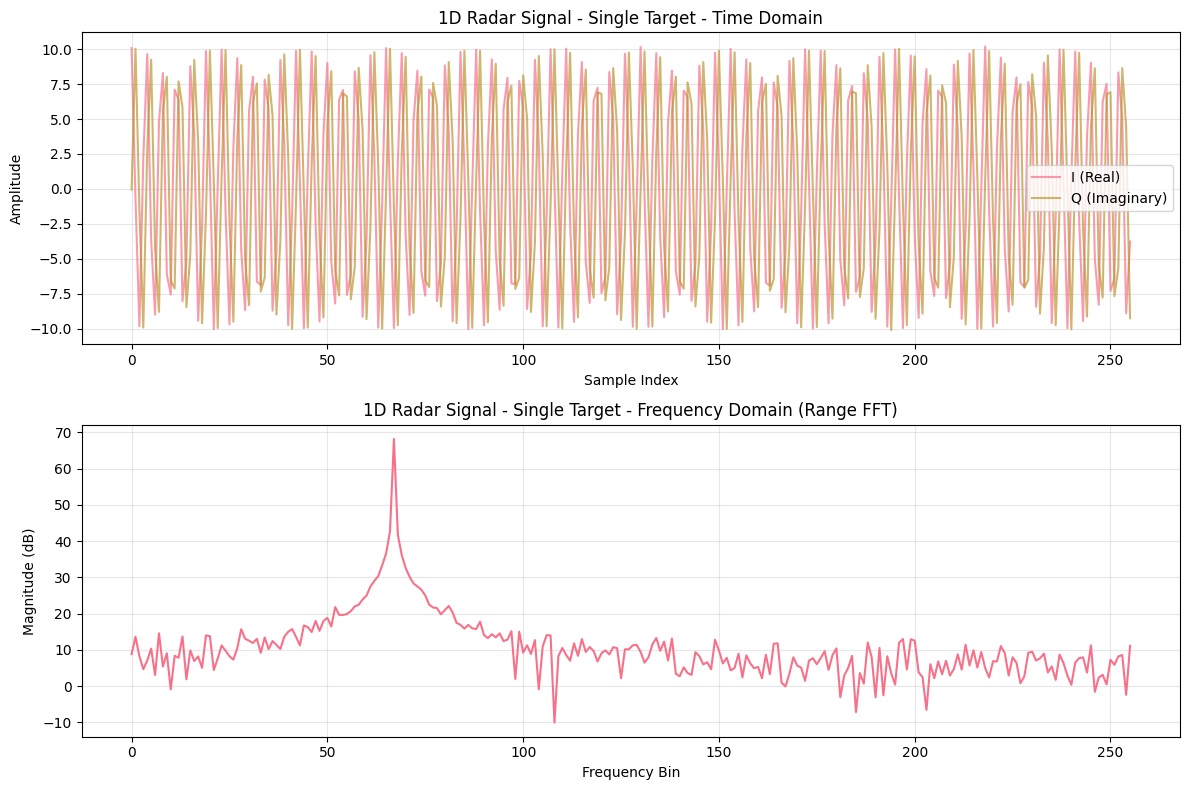

In [31]:
# Generate 1D signal
signal_1d = radar_gen.generate_1d_signal(
target_range=2.5,
target_velocity=1.0,
rcs=10.0,
noise_power=0.01
)

visualizer.plot_1d_signal(
    signal_1d,
    title="1D Radar Signal - Single Target",
    save_path="outputs/1d_signal.png"
)

### 2D Signal Processing

2D Signal Processing - Empty Room

Saved: outputs/empty_room_heatmap.png


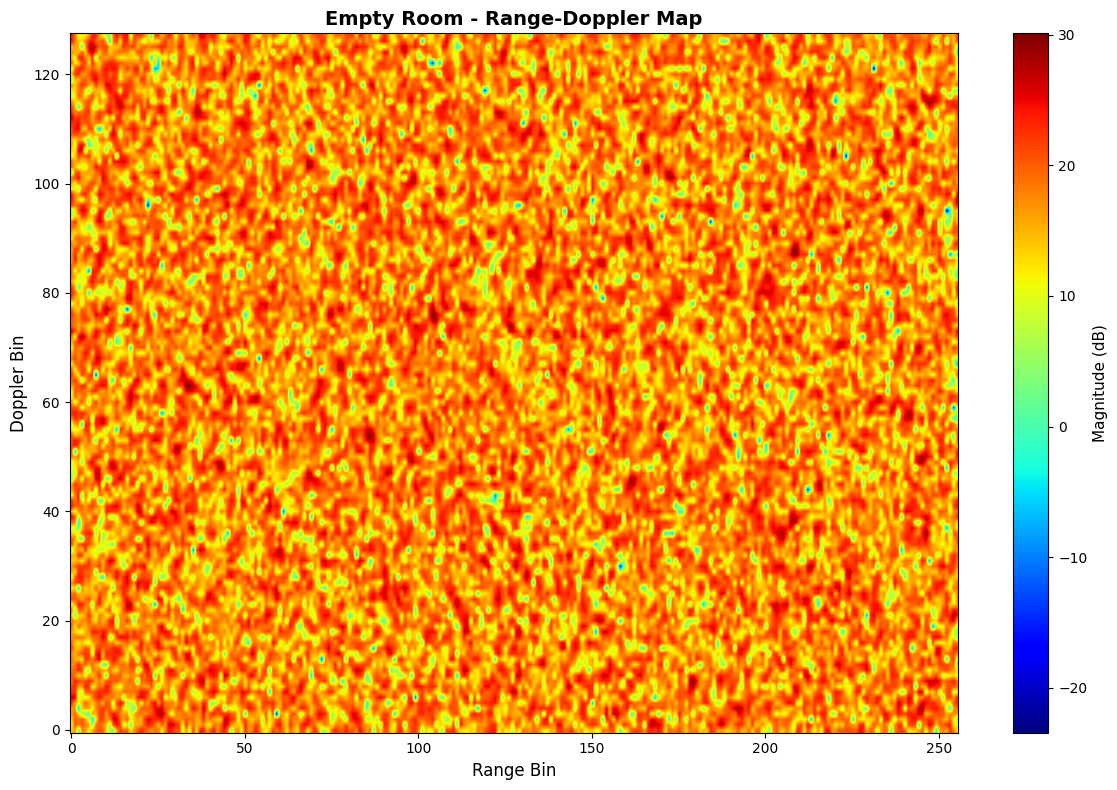

In [32]:
# Empty room scenario
signal_empty = scenario_gen.empty_room()
range_fft_empty = processor.range_fft(signal_empty)
rd_map_empty = processor.doppler_fft(range_fft_empty)
rd_mag_empty = processor.compute_magnitude(rd_map_empty, db=True)

visualizer.plot_range_doppler(
    rd_mag_empty,
    title="Empty Room - Range-Doppler Map",
    save_path="outputs/empty_room_heatmap.png"
)


2D Signal Processing - Single Metal Object

Saved: outputs/metal_object_heatmap.png


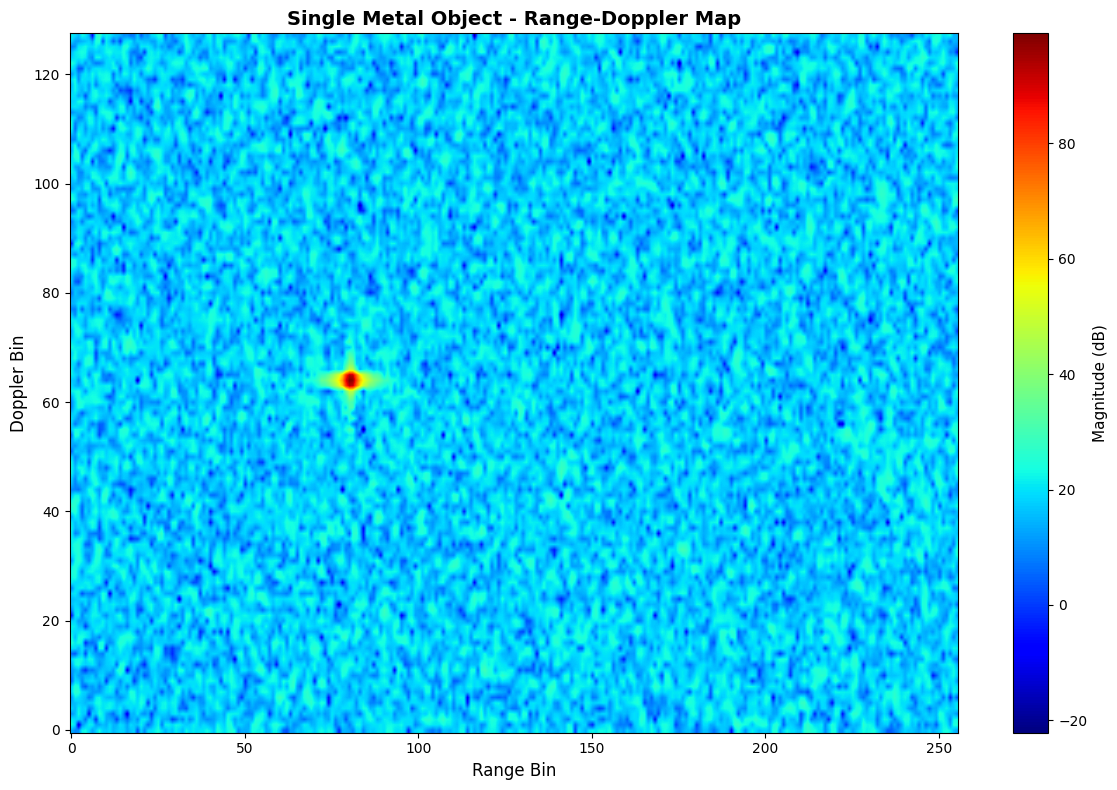

In [33]:
# Single metal object
signal_metal = scenario_gen.single_metal_object(
    range_m=3.0,
    velocity_mps=1.5,
    rcs=12.0
)
range_fft_metal = processor.range_fft(signal_metal)
rd_map_metal = processor.doppler_fft(range_fft_metal)
rd_mag_metal = processor.compute_magnitude(rd_map_metal, db=True)

visualizer.plot_range_doppler(
    rd_mag_metal,
    title="Single Metal Object - Range-Doppler Map",
    save_path="outputs/metal_object_heatmap.png"
)

2D Signal Processing - Multiple Objects

Saved: outputs/multiple_objects_heatmap.png


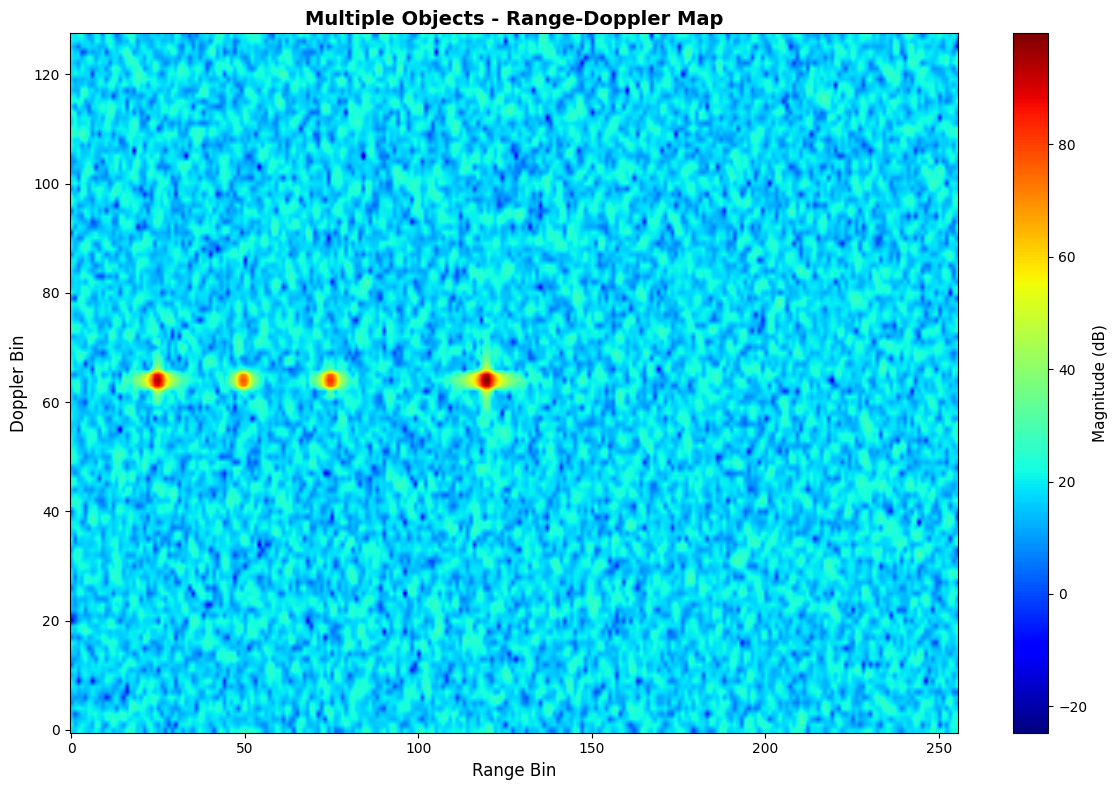

In [35]:
# Multiple objects
signal_multi, targets = scenario_gen.multiple_objects(num_objects=4)
range_fft_multi = processor.range_fft(signal_multi)
rd_map_multi = processor.doppler_fft(range_fft_multi)
rd_mag_multi = processor.compute_magnitude(rd_map_multi, db=True)

visualizer.plot_range_doppler(
    rd_mag_multi,
    title="Multiple Objects - Range-Doppler Map",
    save_path="outputs/multiple_objects_heatmap.png"
)

In [36]:
print("\nTarget Information:")
for i, target in enumerate(targets):
    print(f"  Target {i+1}: Range={target['range']:.2f}m, "
          f"Velocity={target['velocity']:.2f}m/s, "
          f"Type={'Metal' if target['is_metal'] else 'Non-Metal'}")


Target Information:
  Target 1: Range=4.46m, Velocity=1.79m/s, Type=Metal
  Target 2: Range=0.92m, Velocity=-0.39m/s, Type=Metal
  Target 3: Range=2.78m, Velocity=0.68m/s, Type=Non-Metal
  Target 4: Range=1.85m, Velocity=-1.04m/s, Type=Non-Metal


2D Signal Processing - Cluttered Scene

Saved: outputs/clutter_scene_heatmap.png


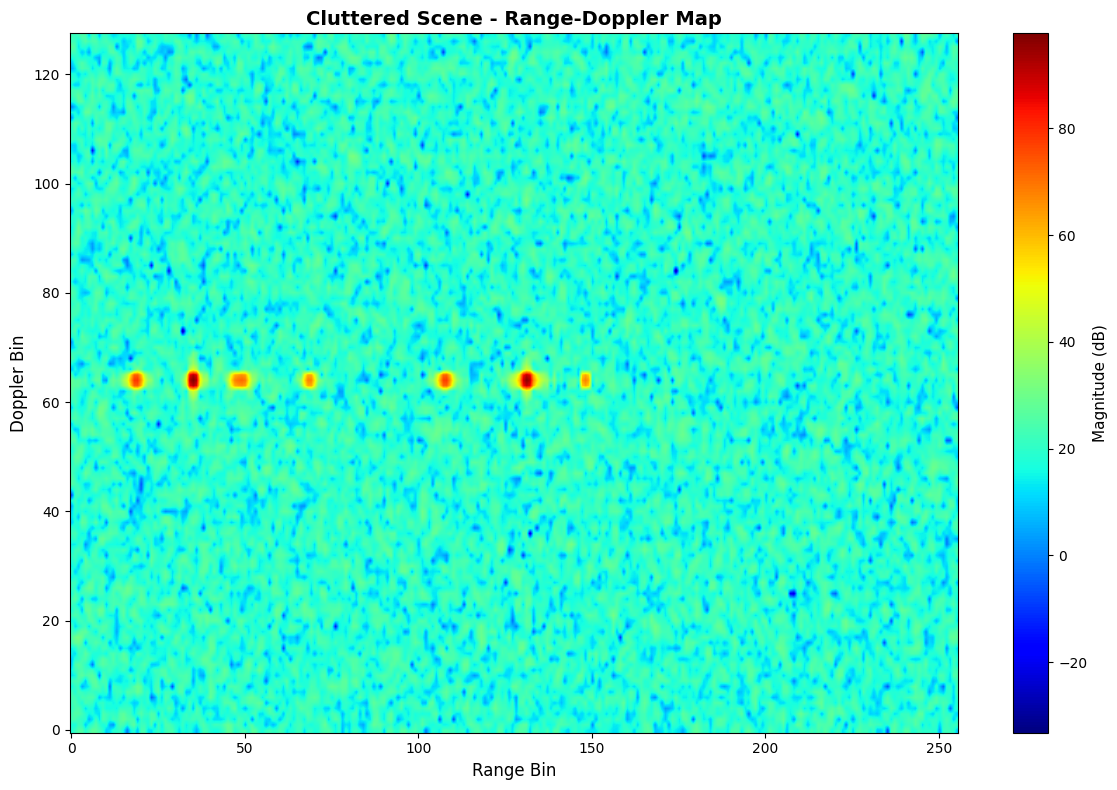

In [37]:
# Cluttered scene
signal_clutter, objects = scenario_gen.cluttered_scene(
    num_clutter=6,
    num_targets=2
)
range_fft_clutter = processor.range_fft(signal_clutter)
rd_map_clutter = processor.doppler_fft(range_fft_clutter)
rd_mag_clutter = processor.compute_magnitude(rd_map_clutter, db=True)

visualizer.plot_range_doppler(
    rd_mag_clutter,
    title="Cluttered Scene - Range-Doppler Map",
    save_path="outputs/clutter_scene_heatmap.png"
)

In [38]:
print("\nScene Objects:")
for i, obj in enumerate(objects):
    obj_type = "Target (Metal)" if obj['is_metal'] else "Clutter"
    print(f"  Object {i+1}: {obj_type}, Range={obj['range']:.2f}m, "
          f"Velocity={obj['velocity']:.2f}m/s")


Scene Objects:
  Object 1: Clutter, Range=5.53m, Velocity=0.28m/s
  Object 2: Clutter, Range=4.02m, Velocity=-0.24m/s
  Object 3: Clutter, Range=0.69m, Velocity=0.02m/s
  Object 4: Clutter, Range=1.84m, Velocity=-0.17m/s
  Object 5: Clutter, Range=1.77m, Velocity=0.09m/s
  Object 6: Clutter, Range=2.56m, Velocity=0.08m/s
  Object 7: Target (Metal), Range=1.31m, Velocity=-1.25m/s
  Object 8: Target (Metal), Range=4.90m, Velocity=-0.62m/s


Comparison Visualization

Saved: outputs/scenarios_comparison.png


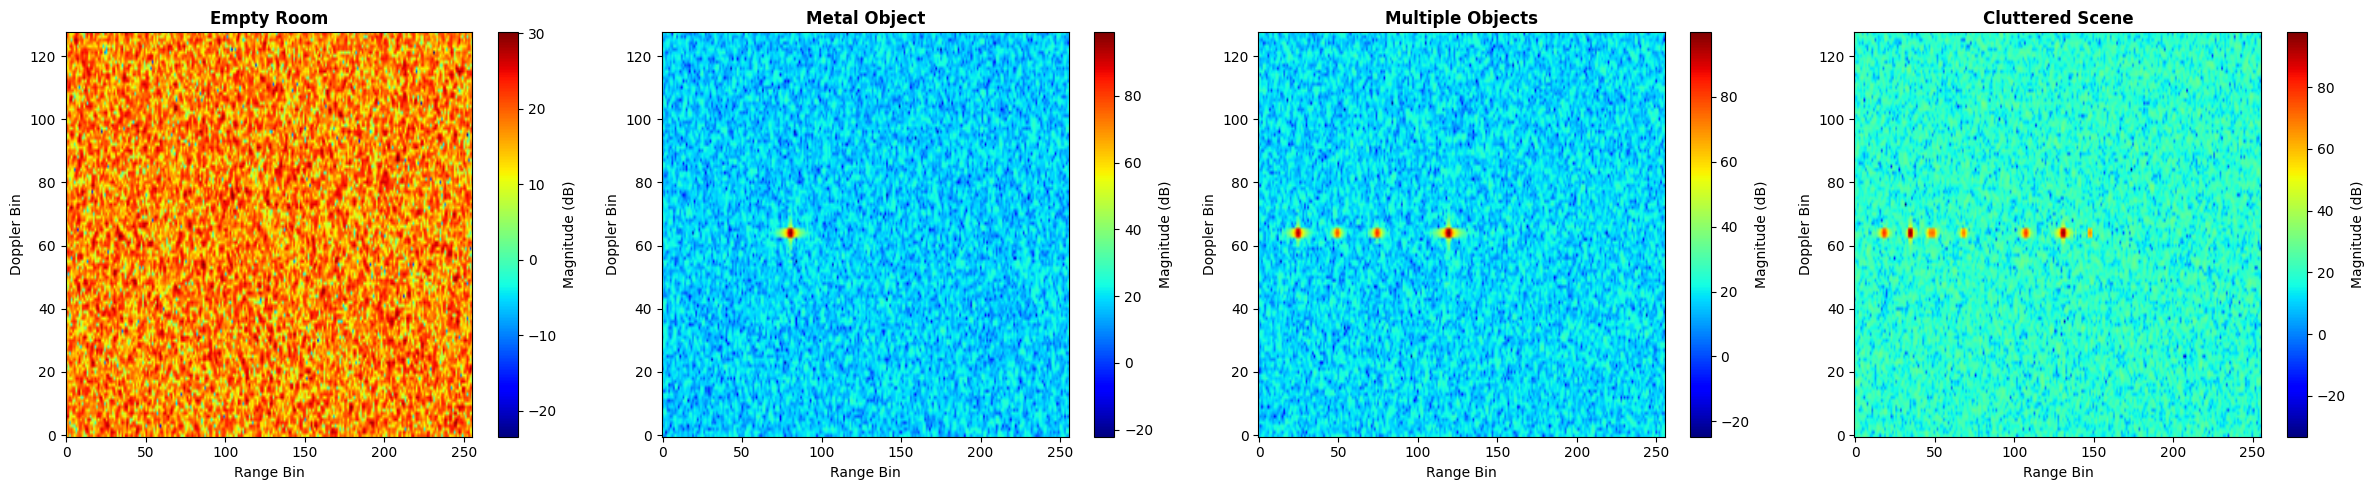

In [39]:
# Create comparison plot
scenarios_dict = {
  "Empty Room": rd_mag_empty,
  "Metal Object": rd_mag_metal,
  "Multiple Objects": rd_mag_multi,
  "Cluttered Scene": rd_mag_clutter
}

visualizer.plot_comparison(
  scenarios_dict,
  save_path="outputs/scenarios_comparison.png"
)
